In [1]:
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
import pandas as pd
df = pd.read_csv('all-data.csv', encoding='latin1')
print(df.shape)
print(df.head())


(4846, 2)
      label                                               text
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [3]:
df.isna().sum()

,0
label,0
text,0


In [4]:
print("Classes:", df['label'].unique())

Classes: ['neutral' 'negative' 'positive']


In [5]:
df['label'].value_counts()

,count
label,
neutral,2879
positive,1363
negative,604


In [6]:
texts = df['text'].values
labels = df['label'].astype('category').cat.codes.values
categories = df['label'].astype('category').cat.categories

# Split the dataset
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)


# **Pipeline A: TF-IDF + Classifier (Baseline)**

In [7]:
vectorizer = TfidfVectorizer(
    max_features=5000,   # limit to top 5000 words (prevents overfitting)
    ngram_range=(1, 2),  # include unigrams + bigrams
    stop_words='english' # remove common English words
)
X_train = vectorizer.fit_transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_predA = clf.predict(X_test)
acc = accuracy_score(y_test, y_predA)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_predA, target_names=categories))


Accuracy: 0.7134020618556701

Classification Report:
               precision    recall  f1-score   support

    negative       0.55      0.69      0.61       121
     neutral       0.80      0.78      0.79       576
    positive       0.62      0.59      0.60       273

    accuracy                           0.71       970
   macro avg       0.66      0.68      0.67       970
weighted avg       0.72      0.71      0.72       970



# **Pipeline B: Word2Vec + Classifier (Semantic Baseline)**

In [ ]:
!pip install gensim

In [29]:
# Very Bad because it doesn't know that a single word change full sentence meaning like "not" and OOV problem that it doesn't know what to do with it
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
import numpy as np
from tqdm import tqdm
df = df.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]  # remove empty strings
# simple_preprocess handles lowercasing and basic cleaning
sentences = [simple_preprocess(str(text)) for text in df["text"]]
import multiprocessing
num_cores = multiprocessing.cpu_count()
#Embedding model
w2v_model = Word2Vec(
    vector_size=300,
    window=5,
    min_count=2,
    sg=1,
    workers=num_cores
)

w2v_model.build_vocab(sentences)
w2v_model.train(
    corpus_iterable=sentences,
    total_examples=w2v_model.corpus_count,
    epochs=200
)

def get_w2v_embedding(text, model, vector_size=300):
    """Return averaged Word2Vec embedding for a given text."""
    words = word_tokenize(text.lower())
    valid_words = [w for w in words if w in model.wv]
    if not valid_words:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_words], axis=0)


In [30]:
print(len(sentences))           # should match df rows
print(sum(len(s) for s in sentences))  # total number of tokens; must be > 0


4846
91327


In [31]:
print("Vocabulary size:", len(w2v_model.wv))
print("Example vector:", w2v_model.wv['company'][:10])


Vocabulary size: 4564
Example vector: [-0.27747512  0.23053211  0.38705254 -0.39524233 -0.21752821 -0.14216623
  0.07904124  0.17146169 -0.45379335 -0.10924418]


In [33]:
w2v_model.wv.most_similar('company', topn=5)


[('introducing', 0.2884933352470398),
 ('bnamericas', 0.2662082314491272),
 ('rmr', 0.2660636901855469),
 ('karppinen', 0.2625717520713806),
 ('nembv', 0.25489920377731323)]

In [34]:
vec = get_w2v_embedding("the company is growing fast", w2v_model)
print(vec.shape)  # should be (300,)


(300,)


In [35]:
# Very Bad because it doesn't know that a single word change full sentence meaning like "not"
X_train = np.vstack([get_w2v_embedding(t, w2v_model) for t in tqdm(X_train_texts)])
X_test  = np.vstack([get_w2v_embedding(t, w2v_model) for t in tqdm(X_test_texts)])
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_predB = clf.predict(X_test)
acc = accuracy_score(y_test, y_predB)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_predB, target_names=categories))

100%|██████████| 970/970 [00:00<00:00, 2574.48it/s]


Accuracy: 0.6494845360824743

Classification Report:
               precision    recall  f1-score   support

    negative       0.45      0.74      0.56       121
     neutral       0.82      0.66      0.73       576
    positive       0.53      0.59      0.56       273

    accuracy                           0.65       970
   macro avg       0.60      0.66      0.62       970
weighted avg       0.69      0.65      0.66       970



# **Pipeline C: Pre-trained Transformer Embedder + Classifier**

In [36]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModel.from_pretrained("yiyanghkust/finbert-tone")

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [37]:
texts = df['text'].values
labels = df['label'].astype('category').cat.codes.values
categories = df['label'].astype('category').cat.categories

In [38]:
from sklearn.model_selection import train_test_split

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels)

In [39]:
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd

def clean_texts(texts):
    """
    Ensures all items are strings and removes NaNs or None.
    """
    # Convert to pandas Series for easy cleaning
    s = pd.Series(texts).dropna().astype(str)
    return s.tolist()

def get_embeddings_batch(texts, batch_size=16, pooling="cls", max_length=256):
    texts = clean_texts(texts)
    all_embeddings = []

    if torch.cuda.is_available():
        model.to("cuda")

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=max_length
        )

        if torch.cuda.is_available():
            inputs = {k: v.to("cuda") for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            if pooling == "mean":
                batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            else:
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()

        all_embeddings.append(batch_embeddings)

    return np.vstack(all_embeddings)


In [40]:
# Using CLS token embedding
X_train = get_embeddings_batch(X_train_texts, batch_size=64)
X_test = get_embeddings_batch(X_test_texts, batch_size=64)
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))

  0%|          | 0/61 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

100%|██████████| 16/16 [00:03<00:00,  4.97it/s]


Accuracy: 0.7793814432989691

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.80      0.75       121
     neutral       0.84      0.80      0.82       576
    positive       0.69      0.72      0.70       273

    accuracy                           0.78       970
   macro avg       0.75      0.78      0.76       970
weighted avg       0.78      0.78      0.78       970



In [41]:
# Using mean pooling embedding
X_train = get_embeddings_batch(X_train_texts, batch_size=64,pooling="mean")
X_test = get_embeddings_batch(X_test_texts, batch_size=64,pooling="mean")
clf = LogisticRegression(max_iter=2000,class_weight="balanced")
clf.fit(X_train, y_train)
y_predC = clf.predict(X_test)
acc = accuracy_score(y_test, y_predC)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=categories))

100%|██████████| 16/16 [00:03<00:00,  4.56it/s]


Accuracy: 0.7845360824742268

Classification Report:
               precision    recall  f1-score   support

    negative       0.71      0.80      0.75       121
     neutral       0.84      0.80      0.82       576
    positive       0.69      0.72      0.70       273

    accuracy                           0.78       970
   macro avg       0.75      0.78      0.76       970
weighted avg       0.78      0.78      0.78       970



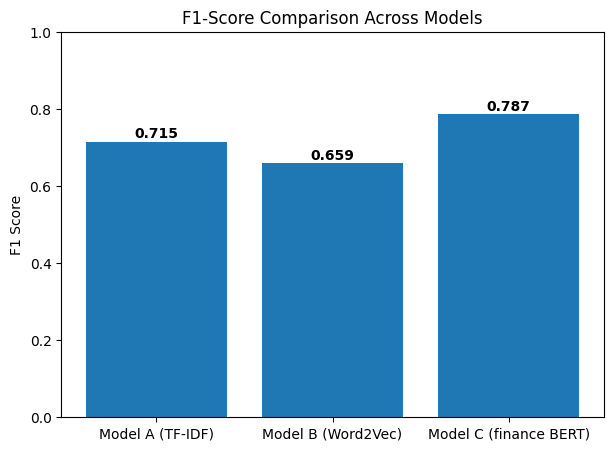

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Compute F1-scores
f1_A = f1_score(y_test, y_predA, average='weighted')
f1_B = f1_score(y_test, y_predB, average='weighted')
f1_C = f1_score(y_test, y_predC, average='weighted')

# Prepare data
models = ['Model A (TF-IDF)', 'Model B (Word2Vec)', 'Model C (finance BERT)']
f1_scores = [f1_A, f1_B, f1_C]

# Plot
plt.figure(figsize=(7, 5))
bars = plt.bar(models, f1_scores)

# Add values on top of bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f"{score:.3f}", ha='center', fontsize=10, weight='bold')

plt.ylabel("F1 Score")
plt.title("F1-Score Comparison Across Models")
plt.ylim(0, 1)
plt.show()
